## Adding RAG to workflow

Add a document database to a workflow

we’ll parse a resume and load it into a vector store, and use the agent to run basic queries against the documents. You’ll use LlamaParse to parse the documents.

## Importing libraries

In [1]:
from IPython.display import display, HTML
from llama_index.utils.workflow import draw_all_possible_flows
import os

## API for workflow

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
import os

def get_openai_api_key():
    """Retrieve the OpenAI API key from environment variables."""
    return os.getenv('OPEN_AI_KEY')

def get_llama_cloud_api_key():
    """Retrieve the Llama Cloud API key from environment variables."""
    return os.getenv('LLAMA_CLOUD_API')

def extract_html_content(filename):
    """Read an HTML file and wrap its content in a scrollable div."""
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            html_content = file.read()
            html_content = f""" <div style="width: 100%; height: 800px; overflow: hidden;"> {html_content} </div>"""
            return html_content
    except Exception as e:
        raise Exception(f"Error reading file: {str(e)}")


You need nested async for this to work, so let's enable it here. It allows you to nest asyncio event loops within each other. 

*Note:* In asynchronous programming, the event loop is like a continuous cycle that manages the execution of code.

In [2]:
import nest_asyncio
nest_asyncio.apply()

You also need two API keys: 
- LLM like you we earlier;
- LlamaCloud API key to use LlamaParse to parse the PDFs.

LlamaParse is an advanced document parser that can read PDFs, Word files, Powerpoints, Excel spreadsheets, and extract information out of complicated PDFs into a form LLMs find easy to understand.

In [6]:
llama_cloud_api_key = get_llama_cloud_api_key()
llm_api_key = os.getenv('GROQ_API')

## Performing Retrieval-Augmented Generation (RAG) on a Resume Document

### 1. Parsing the Resume Document 

Let's start by parsing a resume.

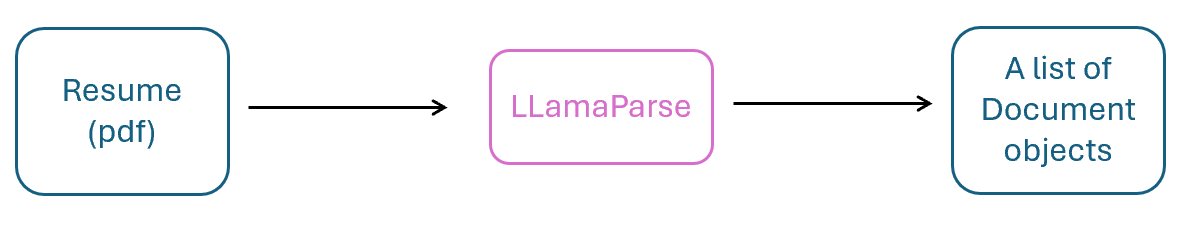

Using LLamaParse, we will transform the resume into a list of Document objects. By default, a Document object stores text along with some other attributes:
- metadata: a dictionary of annotations that can be appended to the text.
- relationships: a dictionary containing relationships to other Documents.
  

You can tell LlamaParse what kind of document it's parsing, so that it will parse the contents more intelligently. In this case, you tell it that it's reading a resume.

In [7]:
from llama_parse import LlamaParse

In [8]:
documents = LlamaParse(
    api_key=llama_cloud_api_key,
    result_type="markdown",
    content_guideline_instruction="This is a resume, gather related facts together and format it as bullet points with headers"
).load_data(
    "data/fake_resume.pdf",
)

Started parsing the file under job_id cb565ae9-8279-4332-bb07-603eb644dc67
